In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tdt
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import xarray as xr
import yaml

import kdephys.hypno as kh
import kdephys.pd as kpd
import kdephys.xr as kx
import kdephys.utils as ku
import kdephys.ssfm as ss

import acr.subjects as subs
import acr
import acr.utils as acu
import plotly.express as px
plt.style.use('acr_plots.mplstyle')
import os
from itertools import cycle

# Generate all Config Files

In [ ]:
params_13 = {}
params_13['subject'] = 'ACR_13'
params_13['stores'] = ['NNXo', 'NNXr', 'EEGr', 'EMGr']
params_13['ds-list'] = ['laser1-bl',
 'laser1-post2',
 'laser1',
 'sdpi-post',
 'sdpi',
 'laser1-post1',
 'sdpi-bl']
params_13['channels'] = {'NNXr':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], 'NNXo':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],
                         "EEGr": [1,2], "EMGr": [1,2]}

acr.info_pipeline.subject_info_gen(params_13)

In [ ]:
params_14 = {}
params_14['subject'] = 'ACR_14'
params_14['raw_stores'] = ['NNXo', 'NNXr', 'EEGr', 'EMGr']
params_14['light_stores'] = ['EEG_', 'EMGr', 'LFP_', 'LFPo' ]
params_14['ds-list'] = ['sdpi-bl',
 'sdpi-post',
 'swi-bl',
 'sdpi',
 'swi',
 'laser1-post1',
 'laser1',
 'swi-sd',
 'laser1-post2',
 'laser1-bl']

params_14['channels'] = {'NNXr':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], 'NNXo':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],
                         "EEGr": [1,2], "EMGr": [1,2], "EEG_": [1,2], "LFP_": [2, 6, 10, 14], "LFPo": [2, 6, 10, 14]}

acr.info_pipeline.subject_info_gen(params_14)

## Get stim info into yaml

In [ ]:
def load_subject_info(subject):
    path = f"/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/{subject}/subject_info.yml"
    with open(path, 'r') as f:
        data = yaml.safe_load(f)
    return data

In [ ]:
def epoc_extractor(subject, recording, epoc_store, t1=0, t2=0):
    # get the subject info file
    info = load_subject_info(subject)
    # get the start time of the recording
    rec_start = np.datetime64(info['rec_times'][recording]['start'])
    rec_end = np.datetime64(info['rec_times'][recording]['end'])
    # load the epocs
    path = info['paths'][recording]
    epocs = tdt.read_block(path, evtype=['epocs'])
    # get the epoc data
    ep = epocs.epocs[epoc_store]
    # get the onsets
    onsets = ep.onset
    # get the offsets
    offsets = ep.offset
    # convert to datetime
    onsets = rec_start + (onsets*1e9).astype('timedelta64[ns]')
    offsets = rec_start + (offsets*1e9).astype('timedelta64[ns]')
    # plot the onsets and offsets:
    dt_range = pd.DatetimeIndex([rec_start, rec_end])
    f, ax = plt.subplots(figsize=(20, 5))
    ax.plot(dt_range, [0, 0], 'k')
    for on, off in zip(onsets, offsets):
        ax.axvline(on, color='green')
        ax.axvline(off, color='red')
        ax.axvspan(on, off, color='blue', alpha=0.2)
    ax.set_xlim(onsets[0] - pd.Timedelta(1, 's'), offsets[-1] + pd.Timedelta(1, 's'))
    
    # return the onsets and offsets
    return onsets, offsets

In [ ]:
def get_wav2_up_data(subject, exp, t1=0, t2=0, store='Wav2', thresh=1.1e6):
    """returns the times where Wav2 store is greater than 1.5, which should equal the laser on times
    """
    info = load_subject_info(subject)
    w = kx.io.get_data(info['paths'][exp], store, t1=t1, t2=t2)
    w_on = w.where(w > thresh, drop=True)
    
    return w_on

In [ ]:
def get_wav2_on_and_off(wav2_up):
    times = wav2_up.datetime.values
    ons = []
    offs = []
    time_int = times[1] - times[0]
    for i in range(len(times)):
        if i == 0:
            ons.append(times[i])
        elif i == (len(times)-1):
            offs.append(times[i])
        else:
            interval = times[i] - times[i-1]
            if interval > (time_int*5):
                ons.append(times[i])
                offs.append(times[i-1])
    f, ax = plt.subplots(figsize=(15, 5))
    ax.plot(wav2_up.datetime, wav2_up.data)
    
    dt_range = pd.DatetimeIndex([ons[0], offs[-1]])
    ax.plot(dt_range, [0, 0], 'k')
    for on, off in zip(ons, offs):
        ax.axvline(on, color='green')
        ax.axvline(off, color='red')
        ax.axvspan(on, off, color='blue', alpha=0.2)
    ax.set_xlim(ons[0] - pd.Timedelta(1, 's'), offs[-1] + pd.Timedelta(1, 's'))
    return ons, offs

In [ ]:

def stim_info_to_yaml(subject, exps):
    path = f"/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/{subject}/subject_info.yml"
    info = load_subject_info(subject)
    
    stim_info = {}
    for exp in exps:
        if exps[exp] != 'Wav2':
            pulse_store = exps[exp]
            on, off = epoc_extractor(subject, exp, exps[exp])
            on_list = list(on)
            on_str = [str(x) for x in on_list]
            off_list = list(off)
            off_str = [str(x) for x in off_list]
            stim_info[exp] = {}
            stim_info[exp][pulse_store] = {}
            stim_info[exp][pulse_store]['onsets'] = on_str
            stim_info[exp][pulse_store]['offsets'] = off_str
        elif exps[exp] == 'Wav2':
            pulse_store = exps[exp]
            wav2_up = get_wav2_up_data(subject, exp)
            on, off = get_wav2_on_and_off(wav2_up)
            on_list = list(on)
            on_str = [str(x) for x in on_list]
            off_list = list(off)
            off_str = [str(x) for x in off_list]
            stim_info[exp] = {}
            stim_info[exp][pulse_store] = {}
            stim_info[exp][pulse_store]['onsets'] = on_str
            stim_info[exp][pulse_store]['offsets'] = off_str
    info['stim_info'] = stim_info
    with open(path, 'w') as f:
        yaml.dump(info, f)
    return

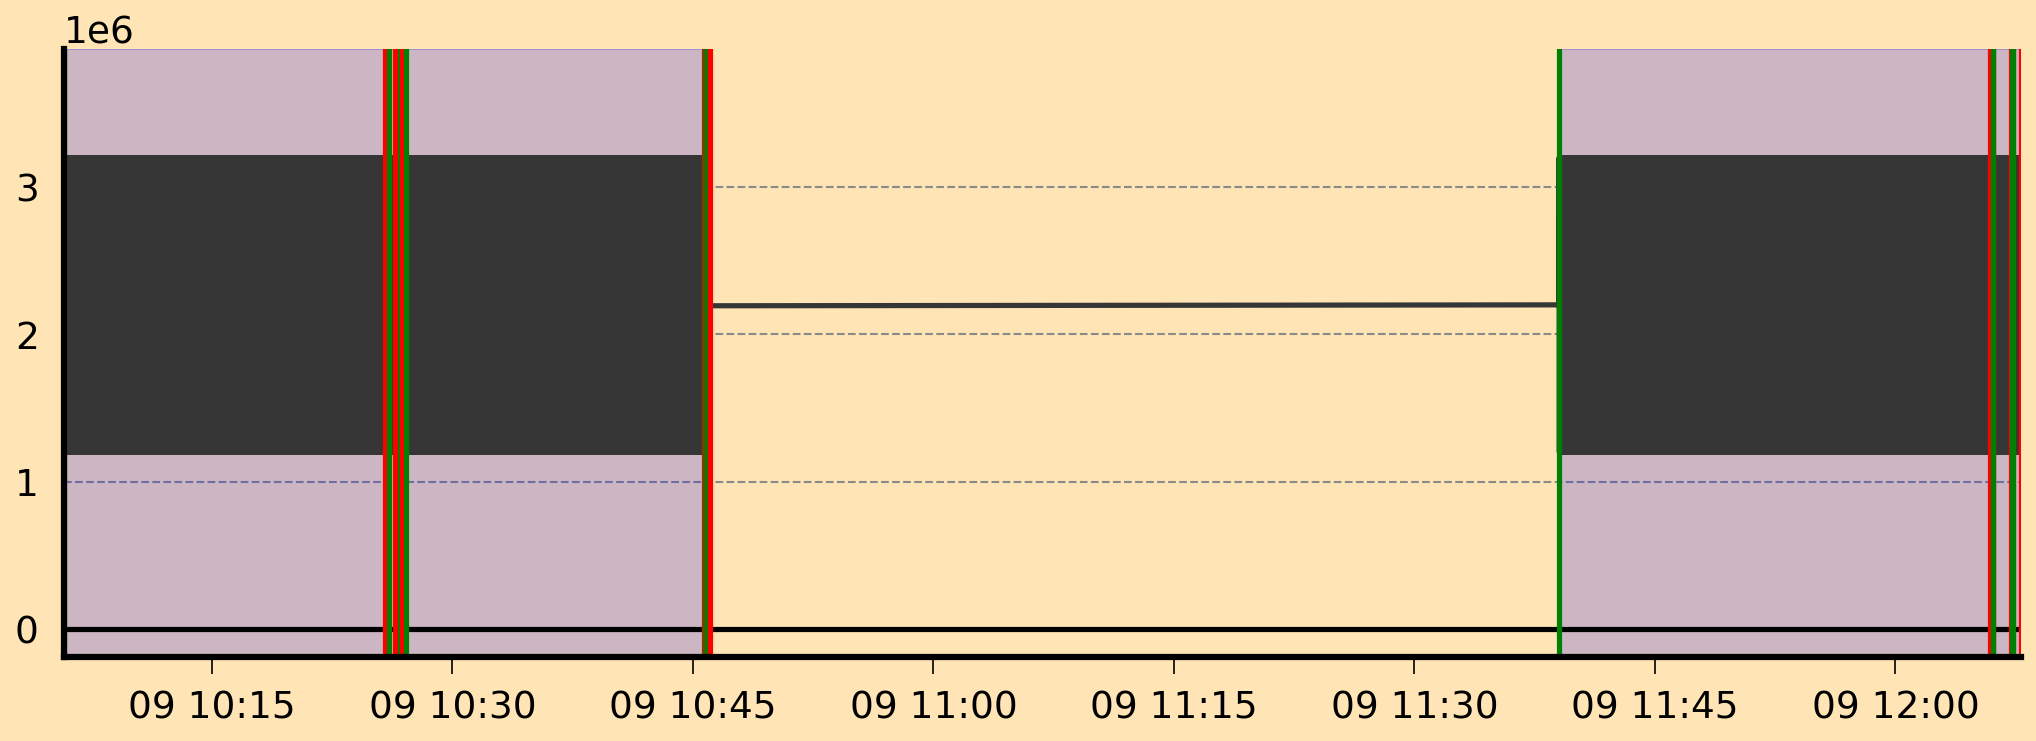

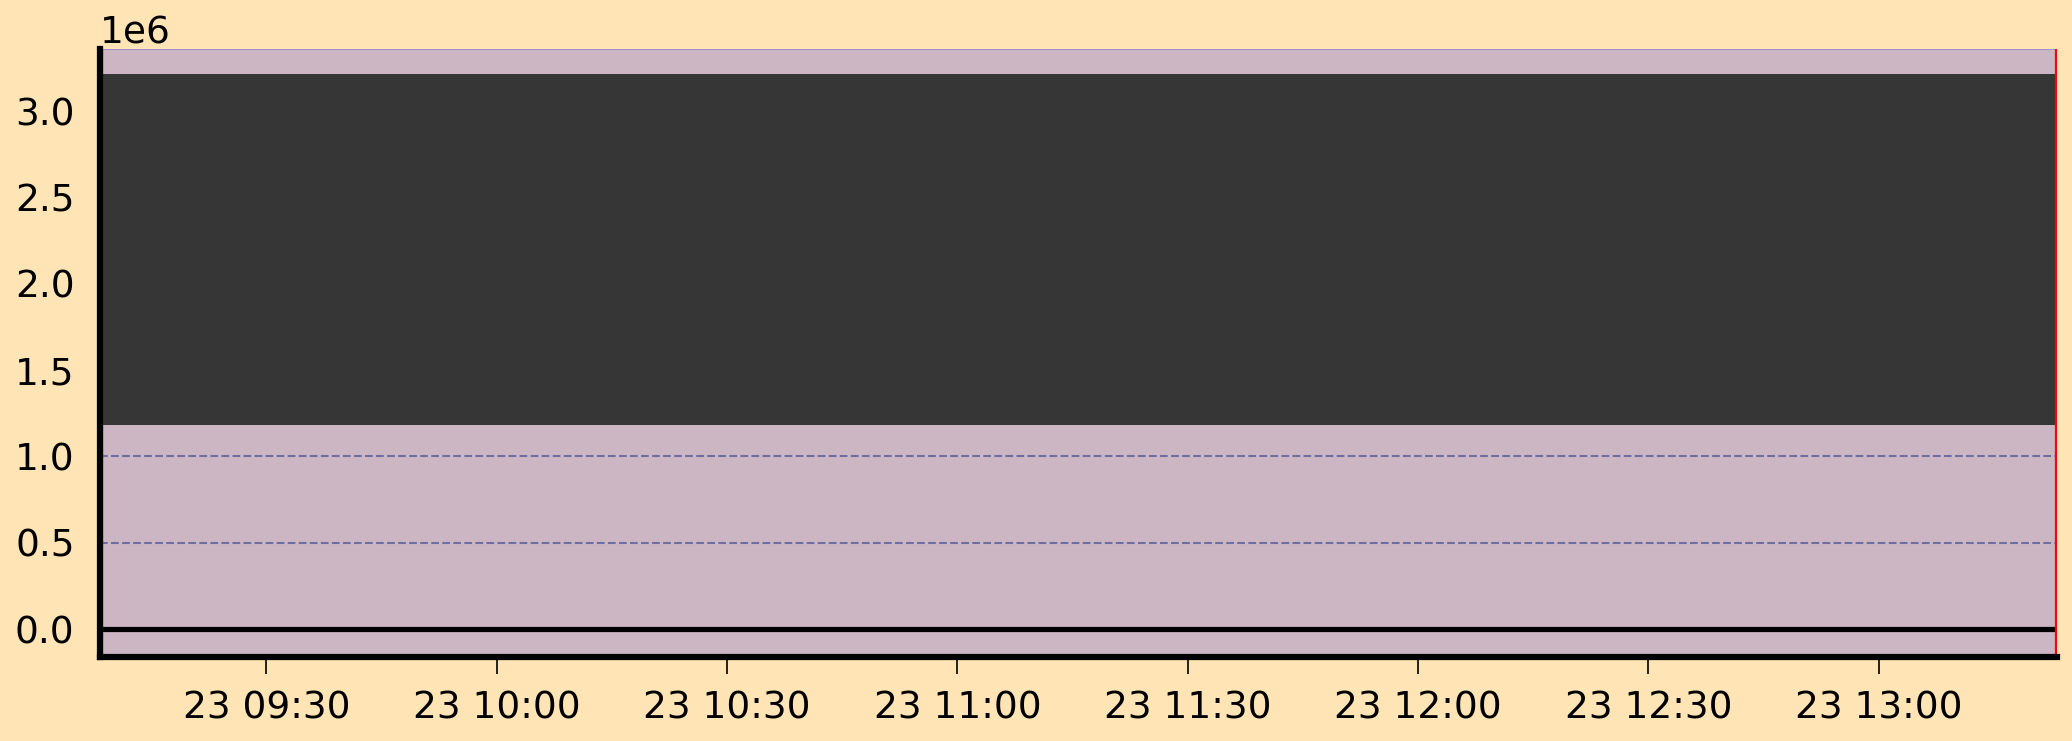

In [44]:
stims_13 = {'laser1':'Wav2', 'sdpi':'Wav2'}
stim_info_to_yaml('ACR_13', stims_13)

In [45]:
stims_14 = {'laser1':'Wav2', 'sdpi':'Wav2', 'swi':'Pu1_'}
stim_info_to_yaml('ACR_14', stims_14)

In [ ]:
def add_stim_mask(onsets, offsets, data, ss_freq=None, pulse_params=False, button_params=False, name='stim'):
    """ss_freq -> the frequency of the sinusiod"""
    
    mask = np.zeros_like(data.datetime.values, dtype=bool)
    for on, off in zip(onsets, offsets):
        mask |= (data.datetime.values >= on) & (data.datetime.values <= off)
    
    # add stim coordinate to the data
    data = data.assign_coords({name: ('datetime', mask)})
    if ss_freq:
        assert len(freq) == 1
        freq_id = name+'-freq'
        data = data.assign_attrs({freq_id: freq[0]})
    if pulse_params:
        on_time = (on[1] - on[0])/np.timedelta64(1, 's')
        freq = 1/on_time
    return data